In [1]:
import pyemma
pyemma.__version__
import numpy as np
import glob
import pyemma.coordinates as coor
import pyemma.msm as msm
import pyemma.plots as mplt
import matplotlib
from matplotlib import pyplot as plt
import sys
import shutil
import os
from pyemma.util.contexts import named_temporary_file
import matplotlib.cm as cm
from collections import defaultdict
from matplotlib import pyplot as plt


def save_trajectory_files(traj_filenames, top_filename, output_file='trajectory_files.npz'):
    """
    保存轨迹文件名列表和拓扑文件名到一个 .npz 文件中。

    参数:
    traj_filenames (list): 轨迹文件名列表
    top_filename (str): 拓扑文件名
    output_file (str): 输出的 .npz 文件名，默认为 'trajectory_files.npz'
    """
    # 检查文件是否存在
    isfile = [os.path.isfile(f) for f in traj_filenames]
    
    # 过滤掉不存在的文件
    traj_filenames = np.array(traj_filenames)[isfile].tolist()
    
    # 保存到 .npz 文件
    np.savez(output_file, files=traj_filenames, top=top_filename)


def plot_free_energy_landscape(Y, output_file='FEL.png'):
    """
    绘制自由能面图并保存为指定文件。

    参数:
    Y (list or np.ndarray): 数据，形状为 (n_samples, n_features)
    output_file (str): 输出文件名，默认为 'FEL.png'
    """
    # 绘制自由能面图
    fig, ax = pyemma.plots.plot_free_energy(
        np.vstack(Y)[:, 0], np.vstack(Y)[:, 1],
        cbar=True
    )
    # 设置坐标轴标签
    ax.set_xlabel('TICA1',fontsize=18, fontweight='bold')
    ax.set_ylabel('TICA2',fontsize=18, fontweight='bold')
    ax.tick_params(labelsize=16)
    # 设置坐标轴范围
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
        # 设置坐标轴比例
    ax.set_aspect('equal')

    # change colorbar font size
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=12)
    # change colorbar label font size
    cbar.ax.set_ylabel('Free Energy (kT)', fontsize=12, fontweight='bold')
    
    # 调整布局
    fig.tight_layout()
    
    # 保存图形
    plt.savefig(output_file, dpi=600)   
    

In [2]:
traj_filenames = ['md.xtc']
top_filename = 'comp.pdb'
output_file = 'trajectory_files.npz'

# check output_file exists or not, if not exsits, create it
if not os.path.exists(output_file):
    save_trajectory_files(traj_filenames, top_filename, output_file)

traj_npz = np.load(output_file)
trajfile = traj_npz['files'].tolist()
topfile = str(traj_npz['top'])

feat = coor.featurizer(topfile)
# feat.add_minrmsd_to_ref(topfile) #minimum RMSD

#region_2 = [i for i in range(91,96)] #beta pleat 8
#region_1 = [i for i in range(149, 154)] #beta pleat 6

# region_2 = [i for i in range(28,32)] #beta pleat 8
# region_1 = [i for i in range(43, 47)] #beta pleat 6

#region_2 = [i for i in range(51,59)] #beta pleat 8
#region_1 = [i for i in range(90,95)] #beta pleat 8

region_2 = [i for i in range(28,31)] #beta pleat 8
region_1 = [i for i in range(63,66)] #beta pleat 8

#region_2 = [i for i in range(13,25)] #beta pleat 8
#region_1 = [i for i in range(91, 96)] #beta pleat 6

#region_2 = [i for i in range(46,54)] #beta pleat 8
#region_1 = [i for i in range(170, 177)] #beta pleat 6

#region_2 = [i for i in range(13,17)] #beta pleat 8
#region_1 = [i for i in range(90, 95)] #beta pleat 6

#region_2 = [i for i in range(17,21)] #beta pleat 8
#region_1 = [i for i in range(172, 176)] #beta pleat 6

# region_2 = [i for i in range(31,36)] #beta pleat 8
# region_1 = [i for i in range(65, 71)] #beta pleat 6
pairs =[]
for i in region_1:
    for j in region_2:
        if i>j:
            pairs.append([i,j])
pairs=np.array(pairs)
feat.add_residue_mindist(pairs,periodic=False) #minimum distance between pairs

X = coor.load(trajfile, feat)
trans_obj = coor.tica(X)
Y = trans_obj.get_output()


/home/ubuntu/.conda/envs/pyemma/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/ubuntu/.conda/envs/pyemma/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


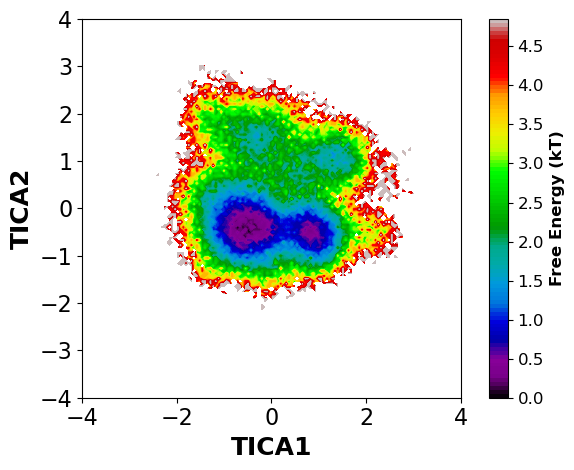

In [3]:
fel_png = "./fel.png"
plot_free_energy_landscape(Y, fel_png)

In [4]:
ncluster = 500
clustering = coor.cluster_kmeans(Y, k=ncluster, max_iter=200, fixed_seed=1)
dtrajs = clustering.dtrajs

/home/ubuntu/.conda/envs/pyemma/lib/python3.11/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/ubuntu/.conda/envs/pyemma/lib/python3.11/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)


initialize kmeans++ centers:   0%|          | 0/500 [00:00<?, ?it/s]

kmeans iterations:   0%|          | 0/200 [00:00<?, ?it/s]

/home/ubuntu/.conda/envs/pyemma/lib/python3.11/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


In [5]:
its = pyemma.msm.its(dtrajs, lags=[1, 2, 5, 10, 15,20, 25, 30, 35, 40, 45], n_jobs=1, errors=None, nits=300)


estimating MaximumLikelihoodMSM:   0%|          | 0/11 [00:00<?, ?it/s]

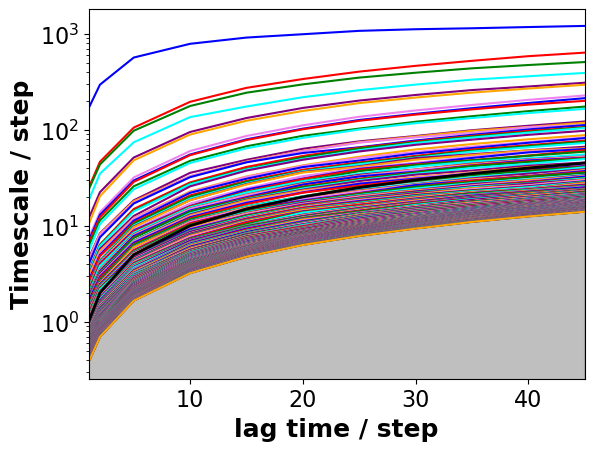

In [6]:
ax = pyemma.plots.plot_implied_timescales(its, units='step')
# set ylabel size
#ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.set_ylabel("Timescale / step", fontsize=18,fontweight='bold')
# set xlabel size
#ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_xlabel("lag time / step", fontsize=18,fontweight='bold')
ax.tick_params(labelsize=16)
plt.savefig("its.png",dpi=600)

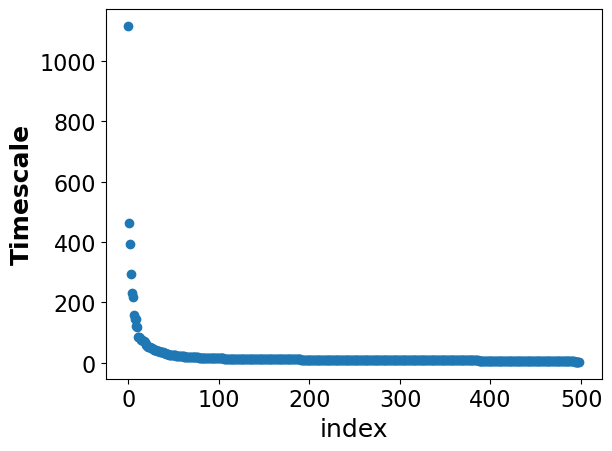

In [7]:
M = msm.estimate_markov_model(dtrajs, lag=30)
plt.plot(M.timescales(), linewidth=0, marker='o')
plt.xlabel('index',fontsize=18)
plt.ylabel('Timescale',fontsize=18,fontweight='bold')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16) 
plt.savefig('./implied_timescale_spectral_analysis.png')

In [8]:
print('fraction of states used = ', M.active_state_fraction)
print('fraction of counts used = ', M.active_count_fraction)

fraction of states used =  1.0
fraction of counts used =  1.0


In [9]:
nstates = 4
M.pcca(nstates)

pcca_dist = M.metastable_distributions
pcca_samples = M.sample_by_distributions(M.metastable_distributions, 1)
torsions_source = pyemma.coordinates.source(trajfile, feat)
pyemma.coordinates.save_trajs(torsions_source,pcca_samples,
    outfiles=['pcca{}-samples.pdb'.format(n + 1)
              for n in range(M.n_metastable)])

['pcca1-samples.pdb',
 'pcca2-samples.pdb',
 'pcca3-samples.pdb',
 'pcca4-samples.pdb']

In [10]:
from itertools import product
mfpt = np.zeros((nstates, nstates))
for i, j in product(range(nstates), repeat=2):
    mfpt[i, j] = M.mfpt(
        M.metastable_sets[i],
        M.metastable_sets[j])
from pandas import DataFrame
mfpt = mfpt*0.05
inverse_mfpt = np.zeros_like(mfpt)
nz = mfpt.nonzero()
inverse_mfpt[nz] = 1.0 / mfpt[nz]
print('MFPT / ns:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), 
columns=range(1, nstates + 1))

MFPT / ns:


,1,2,3,4
1,0.00,235.96,205.43,55.45
2,2210.73,0.00,141.04,25.97
3,2212.52,172.90,0.00,22.76
4,2185.51,183.56,147.36,0.00


In [11]:
print(inverse_mfpt)

[[0.         0.00423793 0.00486782 0.01803301]
 [0.00045234 0.         0.00709024 0.03851305]
 [0.00045197 0.00578381 0.         0.04393538]
 [0.00045756 0.00544775 0.0067862  0.        ]]


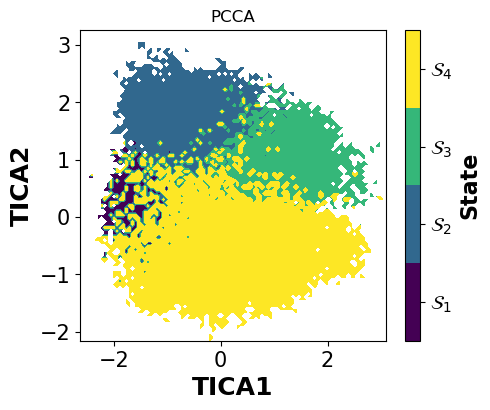

In [12]:
dtrajs_concatenated=np.concatenate(dtrajs)
tica_concatenated=np.concatenate(Y)
pcca_dist = M.metastable_distributions
metastable_traj = M.metastable_assignments[dtrajs_concatenated]
fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('TICA1',fontsize=18,fontweight='bold')
ax.set_ylabel('TICA2',fontsize=18,fontweight='bold')
ax.tick_params(labelsize=15)
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])

# change colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
# change colorbar label font size
cbar.ax.set_ylabel('State', fontsize=16, fontweight='bold')

fig.tight_layout()
plt.title('PCCA')
plt.savefig('Pcca.png',dpi=600)

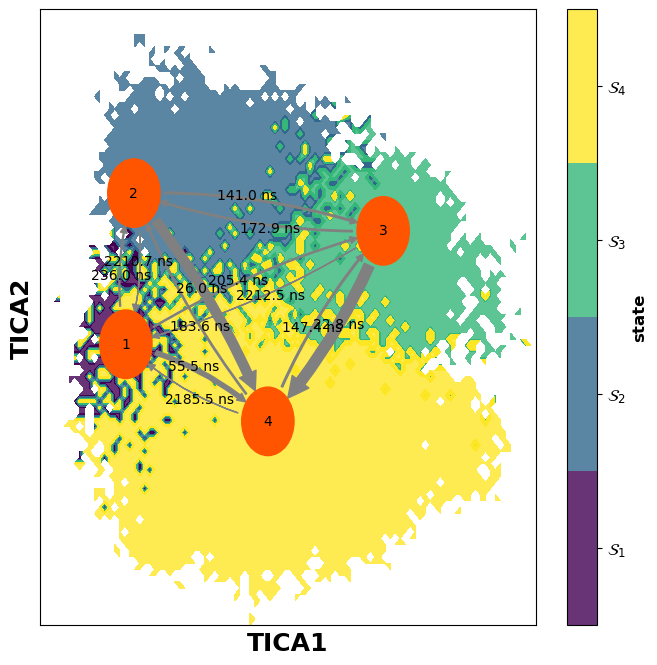

In [13]:
# create state labels according to nstates
state_labels = ['{}'.format(i+1) for i in range(nstates)]
highest_membership = M.metastable_distributions.argmax(1)
coarse_state_centers = clustering.clustercenters[M.active_set[highest_membership]]
fig, ax = plt.subplots(figsize=(8,8))
metastable_traj = M.metastable_assignments[dtrajs_concatenated]
_, _, misc = pyemma.plots.plot_state_map(*tica_concatenated[:, :2].T, metastable_traj, ax=ax, alpha =0.8, zorder=-1)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1) for i in range(nstates)])
pyemma.plots.plot_network(
    inverse_mfpt,
    pos=coarse_state_centers[:,:2],
    arrow_label_format='%.1f ns',
    arrow_labels=mfpt,
    arrow_scale=1.5,
    ax=ax,
    state_labels=range(1, nstates + 1),
    state_sizes=np.array([0.1, 0.1, 0.1,0.1]),
    size=10,alpha=1, show_frame=True);
ax.set_xlabel('TICA1',fontsize=18,fontweight='bold')
ax.set_ylabel('TICA2',fontsize=18,fontweight='bold')
ax.set_xlim(tica_concatenated[:,0].min(), tica_concatenated[:,0].max())
ax.set_ylim(tica_concatenated[:,1].min(), tica_concatenated[:,1].max())

# change colorbar font size
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
# change colorbar label font size
cbar.ax.set_ylabel('state', fontsize=12, fontweight='bold')

plt.savefig("invMFPT.png",dpi=600)

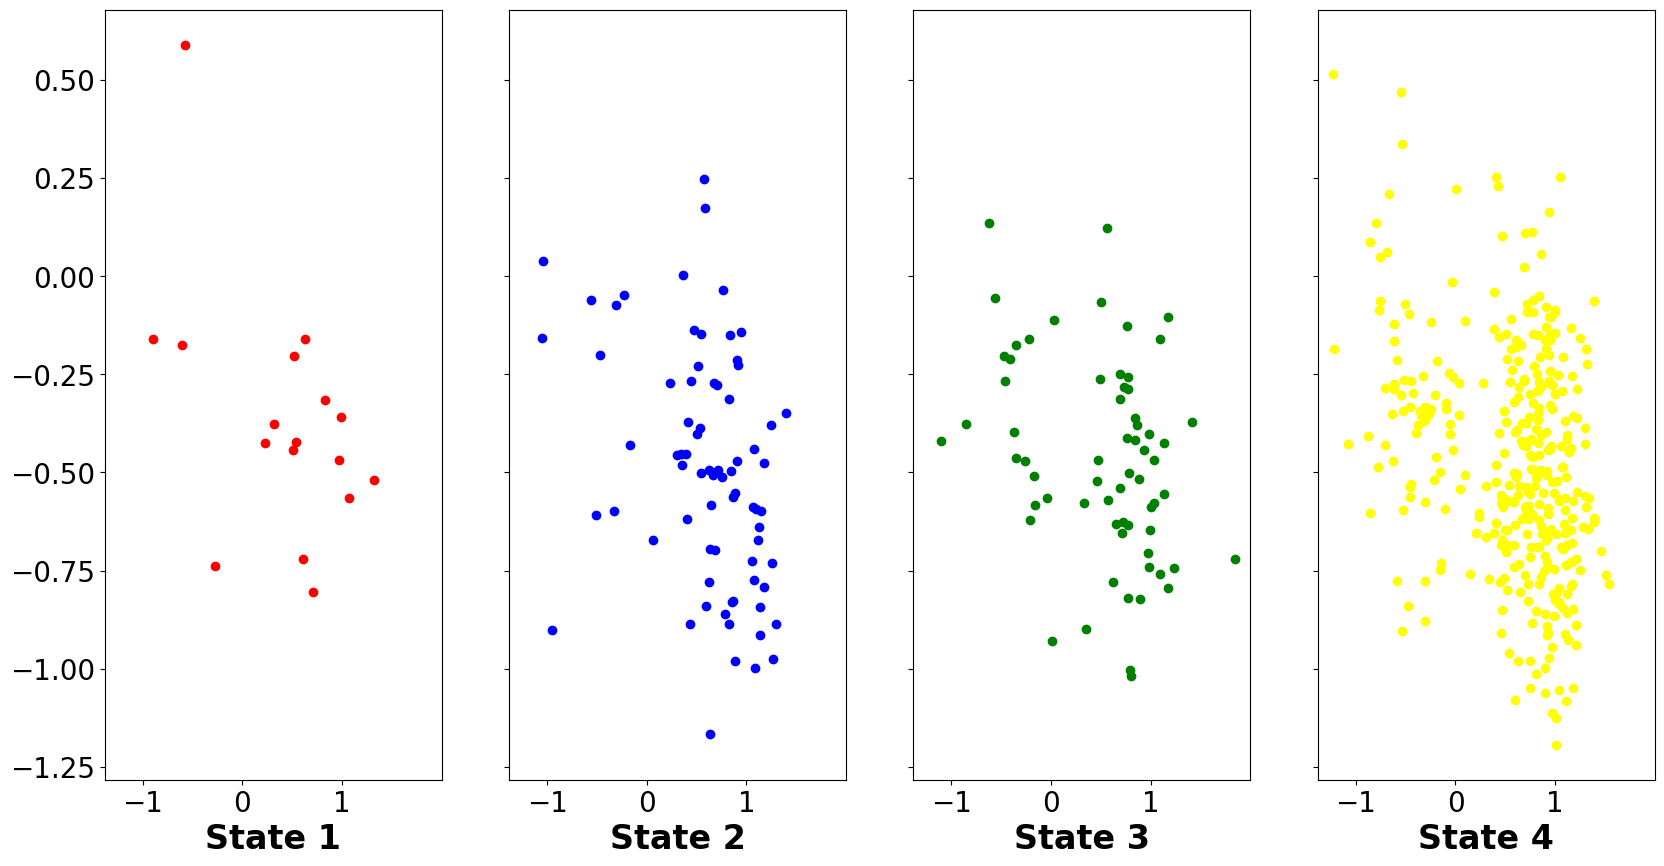

In [14]:
M.metastable_assignments.shape #used to figure out the splicing 
tica=Y[0]
color = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'black', 'gray', 'olive', 'cyan', 'magenta', 'lime', 'teal', 'navy', 'maroon', 'silver', 'gold', 'coral', 'tomato', 'chocolate', 'sienna', 'peru', 'tan','rosybrown', 'saddlebrown', 'darkgray']
fig,ax=plt.subplots(1, nstates,figsize=(20,10), sharex=True, sharey=True)
# loop ax and tica for plotting each subplot
for i in range(nstates):
    ax[i].scatter(tica[0:ncluster,0][M.metastable_assignments==i], tica[0:ncluster,1][M.metastable_assignments==i], c=color[i])#the slicing was used to adjust the size
    ax[i].set_xlabel('State {}'.format(i+1), fontsize=24,fontweight='bold')
    ax[i].tick_params(labelsize=20)
# save figure
#ax.tick_params(labelsize=12)   
plt.savefig('./msm_cluster.png', dpi=600)

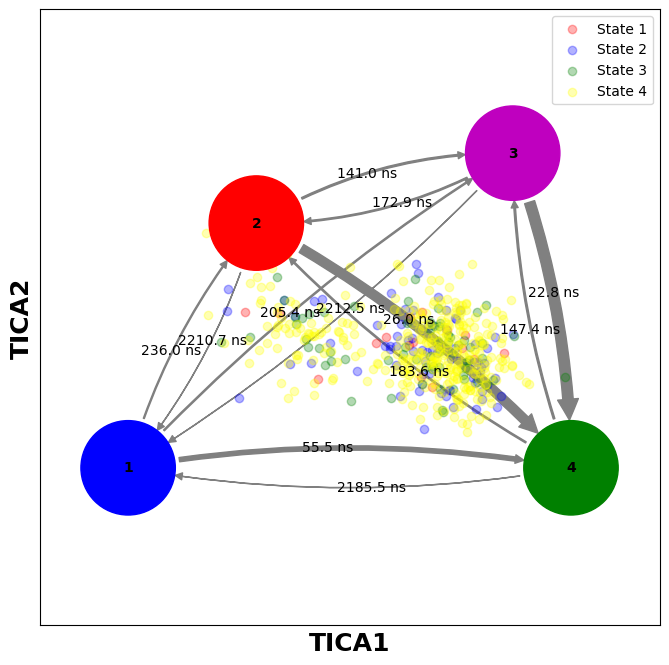

In [17]:
# creates the transition graph
fig,ax=plt.subplots(1,1,figsize=(8,8))
tica_concatenated=np.concatenate(Y)

highest_membership = M.metastable_distributions.argmax(1)
coarse_state_centers = np.array([ [-1.9,-1.5],[-0.8,0.6],[1.4,1.2],[1.9,-1.5]])
#coarse_state_centers = np.array([ [-1.2,-2.2],[1.4, -2.2],[0.2,0.6]])
#coarse_state_centers = np.array([ [-0.4,0.6],[-1.0, 0.2],[-1.0,0.8],[1.0,0.6],[0.7,-0.6]])
size = np.array([0.0001, 0.0001, 0.0001,0.0001])
#colors=('b','r','m','g','c')
#colors=('b','r','m')
colors=('b','r','m','g')
ax.set_xlabel('TICA1', fontsize=18,fontweight='bold')
ax.set_ylabel('TICA2', fontsize=18,fontweight='bold')
ax.set_xlim(tica_concatenated[:,0].min(), tica_concatenated[:,0].max())
ax.set_ylim(tica_concatenated[:,1].min(), tica_concatenated[:,1].max())
# loop through the states for ax.scatter
for i in range(nstates):
    ax.scatter(coarse_state_centers[i,0], coarse_state_centers[i,1], marker='o', s=size[i], color=colors[i])
    ax.scatter(tica[0:ncluster,0][M.metastable_assignments==i], tica[0:ncluster,1][M.metastable_assignments==i],label='State {}'.format(i+1), c=color[i],alpha=0.3)

# coarse_state_centers = clustering.clustercenters[M.active_set[highest_membership]]
# pyemma.plots.plot_network(
#     inverse_mfpt,
#     pos=coarse_state_centers[:,:2],
#     arrow_label_format='%.1f ns',
#     arrow_labels=mfpt,
#     arrow_scale=1.5,
#     ax=ax,state_colors=colors,
#     state_labels=range(1, nstates + 1),
#     state_sizes=np.array([0.1, 0.1, 0.1]),
#     size=10,alpha=1, show_frame=True);

pyemma.plots.plot_network(inverse_mfpt,pos=coarse_state_centers[:,:3],
    arrow_label_format='%.1f ns',arrow_labels=mfpt,arrow_scale=1.5,
    state_colors=colors,ax=ax,state_labels=range(1, nstates + 1),
    size=10,alpha=1, show_frame=True,fontweight='bold');
plt.legend()
plt.savefig('transition_graph.png',dpi=600)

In [18]:
# histogram data
Y_new = Y[0]

coarse_state_centers = clustering.clustercenters[M.active_set[highest_membership]]
print((coarse_state_centers.shape))

(4, 8)


In [19]:
# 获取每个微观状态属于每个亚稳态的概率
pcca_memberships = M.metastable_memberships

# 获取亚稳态的稳定分布
stationary_distribution = M.pi
metastable_probs = np.dot(stationary_distribution, pcca_memberships)
print("Metastable state probabilities:", metastable_probs)

Metastable state probabilities: [0.03008456 0.21820772 0.16611578 0.58559194]


/tmp/ipykernel_6168/2071288626.py:3: RuntimeWarning: divide by zero encountered in log
  F = -np.log(z)
/tmp/ipykernel_6168/2071288626.py:17: UserWarning: The following kwargs were not used by contour: 'cbar'
  cs = ax.contourf(F.T, 50, cmap=plt.cm.Spectral, extent=extent, alpha=1, cbar=True)


86.02749687370428
-6.597616158854731
51.608111815426064
-22.52409846605388


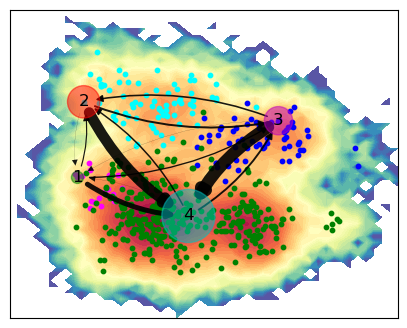

In [20]:
z,x,y = np.histogram2d(Y_new[:, 0], Y_new[:, 1], bins=50)
# compute free energies
F = -np.log(z)
# contour plot
extent = [x[0], x[-1], y[0], y[-1]]

cc_x = clustering.clustercenters[:, 0]
cc_y = clustering.clustercenters[:, 1]

# plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(5,4))
pcca_sets = M.metastable_sets

dtrajs_concatenated=np.concatenate(dtrajs)
# F = M.pi[dtrajs_concatenated]

cs = ax.contourf(F.T, 50, cmap=plt.cm.Spectral, extent=extent, alpha=1, cbar=True)

# cbar = fig.colorbar(cs)
# set cbar ticks to keep one digit after decimal point
# cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

size = 10
cols = [ 'magenta', 'cyan',  'blue', 'green','black','orange',]
for i in range(nstates):
    plt.scatter(cc_x[pcca_sets[i]], cc_y[pcca_sets[i]], color=cols[i], s=size)

coarse_state_centers = clustering.clustercenters[M.active_set[highest_membership]]

import networkx as nx

# 定义状态的坐标
# coarse_state_centers shape (3, 14), only keep the first 2 columns
coarse_state_centers_2dim = coarse_state_centers[:, :2]
states = coarse_state_centers_2dim
# 定义3个状态之间的跃迁概率矩阵
transition_matrix = inverse_mfpt*10
# 定义3个状态的静态分布概率
pro_states = metastable_probs

# 创建一个有向多重图
G = nx.MultiDiGraph()

# 添加节点并根据静态分布概率来设置节点的大小
for i, (state, prob) in enumerate(zip(states, pro_states)):
    G.add_node(i, pos=state, size=prob * 2500)  # size根据概率放大1000倍，方便可视化

# 添加带有权重的边（跃迁概率）
for i in range(len(transition_matrix)):
    for j in range(len(transition_matrix[i])):
        if transition_matrix[i][j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i][j])

# 获取节点位置和大小
pos = nx.get_node_attributes(G, 'pos')
sizes = [nx.get_node_attributes(G, 'size')[i] for i in G.nodes()]

# 绘制节点
colors=('g','r','m','c')
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=colors, alpha=0.5)

# 绘制带有权重的边，并增加弯曲度
edges = G.edges(data=True)
weights = [edge[2]['weight'] * 10 for edge in edges]  # 将权重放大10倍，方便可视化

# get graph nodes position
pos = nx.get_node_attributes(G, 'pos')
user_defined_pos = {}
delta_y = 0.2
delta_x = 0.4
for i in G.nodes():
    if i < len(G.nodes()) - 1:
        pos_new = (pos[i] + pos[i+1])/2
        pos_new1, pos_new2 = pos[i], pos[i+1]

    elif i == len(G.nodes()) - 1:
        pos_new = (pos[i] + pos[0])/2
        pos_new1, pos_new2 = pos[i], pos[0]

    
    d_x = pos_new2[0] - pos_new1[0]
    d_y = pos_new2[1] - pos_new1[1]
    tan_value =  d_y / d_x
    import math
    angle_radians = math.atan(tan_value)
    angle_degrees = math.degrees(angle_radians)

    print(angle_degrees)

    if abs(angle_degrees) <= 45:
        user_defined_pos[i*2] = (pos_new[0], pos_new[1] + delta_y)
        user_defined_pos[i*2+1] = (pos_new[0], pos_new[1] - delta_y)
    else:
        user_defined_pos[i*2] = (pos_new[0] + delta_x, pos_new[1]  )
        user_defined_pos[i*2+1] = (pos_new[0] - delta_x, pos_new[1]  )


    
# print(user_defined_pos)
new_data = []
for (u, v, data) in edges:
    rad = 0.15  # 设置边的弯曲度
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=data['weight'] * 20, alpha=0.9, edge_color='black', connectionstyle=f'arc3,rad={rad}')
    # show edges labels with transimtion matrix
    # nx.draw_networkx_edge_labels(G, pos=user_defined_pos, edge_labels={(u, v): f'{data["weight"]:.2f}'}, font_size=10, label_pos=0.3)
    new_data.append(data['weight'])
# draw labels on pos user_defined_pos
# print(new_data)
# nx.draw_networkx_labels(G, pos=user_defined_pos, labels={i: f'{new_data[i]:.4f}' for i in range(len(edges))})




# 添加标签
# plot node labels i+1 
nx.draw_networkx_labels(G, pos, labels={i: str(i+1) for i in G.nodes()}, font_size=12, font_color='black')
# nx.draw_networkx_labels(G, pos, font_size=12, font_color='black')

# 显示图形
# plt.title("Transition Probability Between States")
# save fig
plt.savefig('transition_probability_between_states.png', dpi=600)
plt.show()


100%|██████████| 9/9 [00:02<00:00,  3.82it/s]                                 


TypeError: legend() takes 0-2 positional arguments but 3 were given

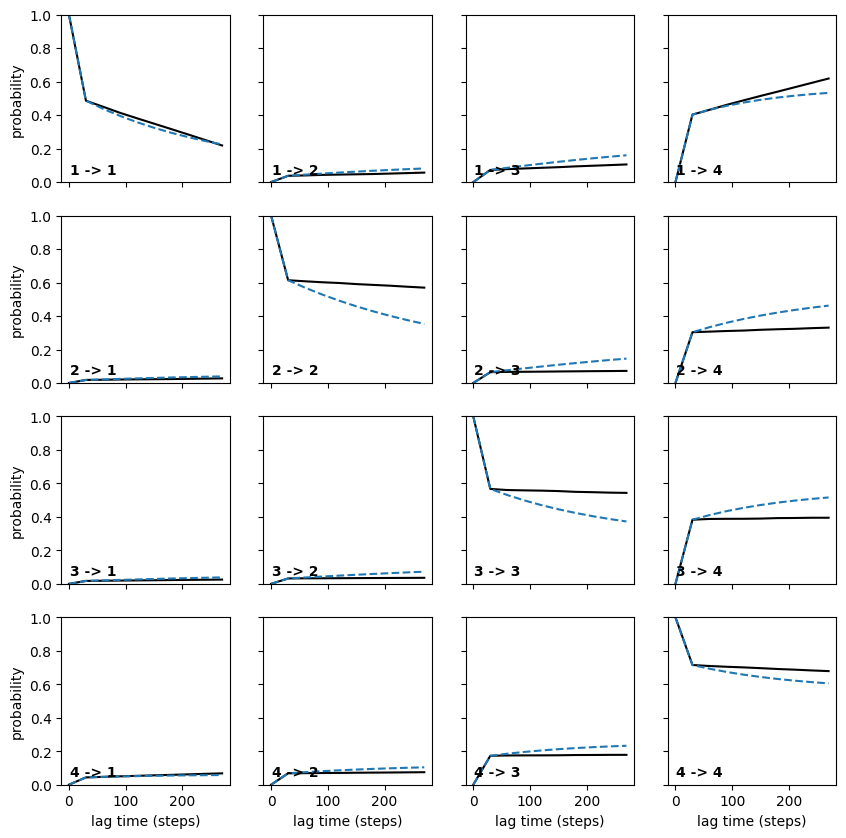

In [22]:
ck_test = True
if(ck_test):
    pyemma.plots.plot_cktest(M.cktest(nstates))
    plt.savefig('./cktest.png')